In [8]:
%load_ext autoreload
%autoreload 2
%aimport
import statistics
from math import lgamma
from src.bayesian import *
from src.packages import *
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import numpy as np
from scipy.stats import beta
from tqdm.notebook import tqdm
from p_tqdm import p_map
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [10, 5]
print("Ссылка на описание байесовского AB-тестирования для базы знаний: \n")
print("https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit")
print(f"Глоссарий: {'https://docs.google.com/document/d/1lYa2S0OlF4ucbXMqWdUF89SDQdfqBJizkf2bYJ3gFjE/edit#'}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

Ссылка на описание байесовского AB-тестирования для базы знаний: 

https://docs.google.com/document/d/1JH4tsAXeVObgKDd73JSCBB6acGZHU3mVDiglAfYopFA/edit
Глоссарий: https://docs.google.com/document/d/1lYa2S0OlF4ucbXMqWdUF89SDQdfqBJizkf2bYJ3gFjE/edit#


# 1. Отличия байесовского подхода от классического

Теперь мы сравниваем два распределения, а не два отдельных значения друг с другом

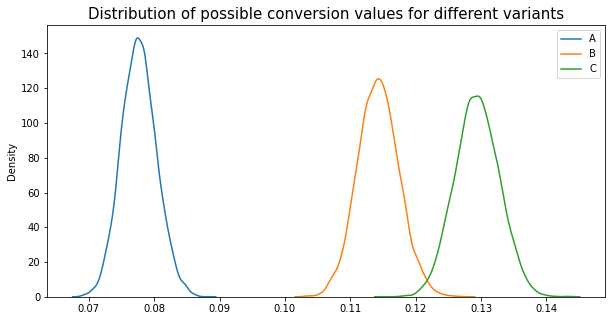

In [9]:
success_conversions = [777, 1143, 1294]
observations = [10000, 10000, 10000]
sns.distplot(np.random.beta(success_conversions[0], observations[0] - success_conversions[0], observations[0]), kde=True, hist=False);
sns.distplot(np.random.beta(success_conversions[1], observations[1] - success_conversions[1], observations[1]), kde=True, hist=False);
sns.distplot(np.random.beta(success_conversions[2], observations[2] - success_conversions[2], observations[2]), kde=True, hist=False);
plt.title("Distribution of possible conversion values for different variants",
          fontdict={"size": 15});
plt.legend(['A', 'B', 'C']);

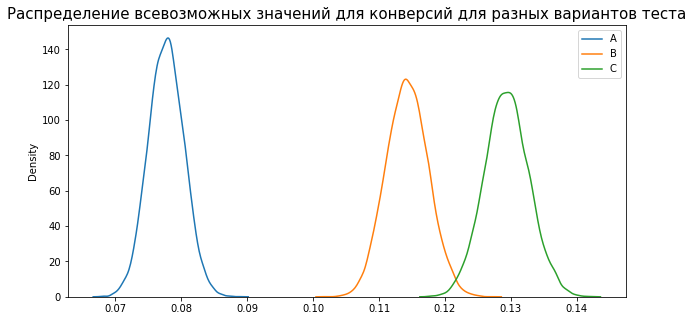

In [10]:
success_conversions = [777, 1143, 1294]
observations = [10000, 10000, 10000]
sns.distplot(np.random.beta(success_conversions[0], observations[0] - success_conversions[0], observations[0]), kde=True, hist=False);
sns.distplot(np.random.beta(success_conversions[1], observations[1] - success_conversions[1], observations[1]), kde=True, hist=False);
sns.distplot(np.random.beta(success_conversions[2], observations[2] - success_conversions[2], observations[2]), kde=True, hist=False);
plt.title("Распределение всевозможных значений для конверсий для разных вариантов теста",
          fontdict={"size": 15});
plt.legend(['A', 'B', 'C']);

In [7]:
get_bayes_metrics(0, p1=0.11, p2=0.13, size=10000)

(0.999991,
 2.255703665273695e-09,
 -0.15476135310962197,
 -0.06256057458676036,
 -0.2177344739132271,
 -0.09110966293176614)

# 2. Принцип работы байесовских тестов
Предполагается некое `априорное распределения` метрик (биномиальные, нормальное,
экспоненциальное и т.д.). Затем, используя полученные `данные (новую информацию)`, мы
пересчитываем все и получаем `апостериорное распределение`.

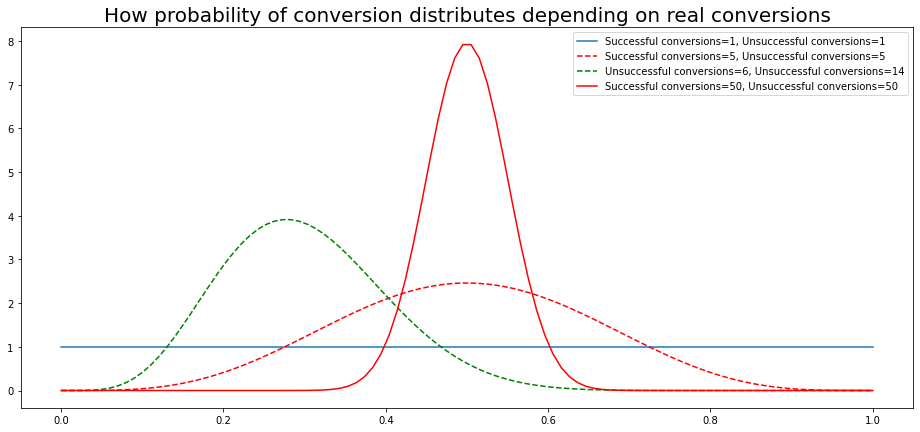

In [12]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 1.0, 100)
y1 = beta.pdf(x, 1, 1)
y2 = beta.pdf(x, 5, 5)
y3 = beta.pdf(x, 6, 14)
y5 = beta.pdf(x, 50, 50)
plt.plot(x, y1, "-", x, y2, "r--", x, y3, "g--", x, y5, "r-");
plt.legend(['Successful conversions=1, Unsuccessful conversions=1',
            'Successful conversions=5, Unsuccessful conversions=5',
            'Unsuccessful conversions=6, Unsuccessful conversions=14',
            'Successful conversions=50, Unsuccessful conversions=50']);
plt.title("How probability of conversion distributes depending on real conversions",
          fontdict={"size": 20});

Рассмотрим пример пересчета плотности распределения конверсий при байесовском AB-тестировании.
Допустим, что на 1 шаге вероятности конверсии у нас одинаковы и равны 0.5. 
Спустя 1 час после эксперимента из 10 пользователей была совершена одна успешная конверсия. Рисунок ниже демонстрирует нам то, как меняется наше априорное распределение о конверсии с учетом новых данных эксперимента. В конечном счете в качестве итоговой оценки дял конверсии мы используем апостериорное распределение. Основная задача в байесовских тестах состоит в сравнении данных распределений друг с другом.

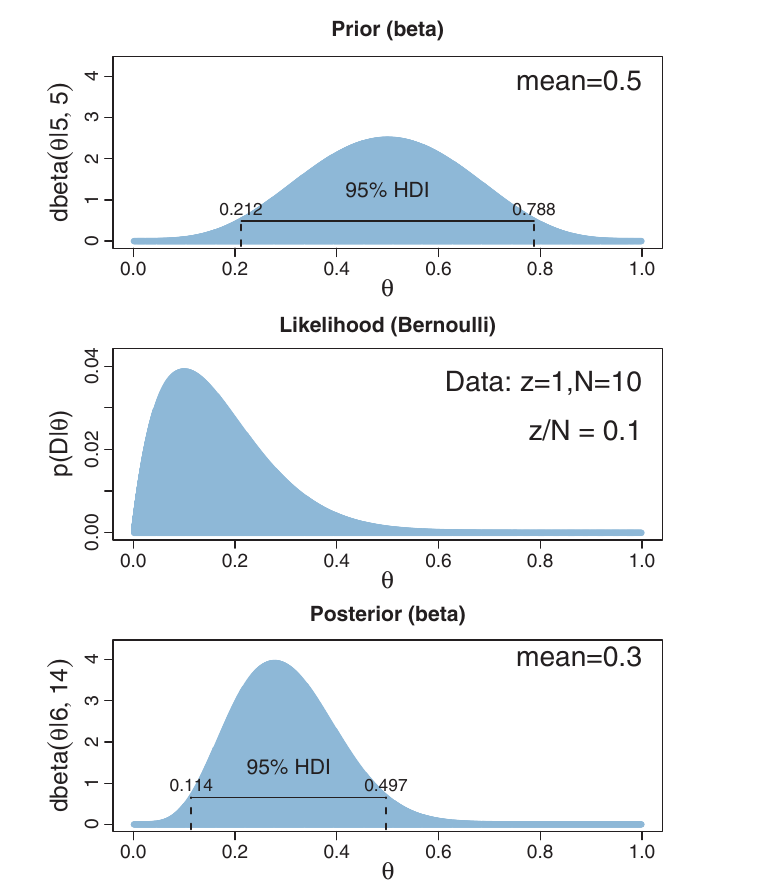

# 3. Основные критерии принятия решений в Байесовских тестах

Основная проблема Байесовских тестов по сравнению с классическими - проблема
контроля ошибки 1 и 2 рода. Особенно это проявляется в случае ранней остановки
алгоритма (когда мы заканчиваем эксперимент при достижении определенных значений
критериев). Ниже будут описаны основные критерии принятия решений
в случае байесовских тестов
(как для алгоритма Томпсона, так и для разбивки 50 на 50).

Критерии принятия решений в VWO:
https://help.vwo.com/hc/en-us/articles/360033471774-What-is-a-Winner-in-VWO-

## 3.1 Вероятность превосходства
Английские термины: *chance to beat control*, *probability superiority*

В случае алгоритма на конверсию у нас в качестве априорного распределения берется
биномиальное. Для того чтобы пересчитать апостериорную вероятность для биномиального
распределения, используется сопряженное ему бета-распределение.
Вероятность превосходства  можно посчитать двумя способами: по точной формуле или при помощи генерации
случайных величин из бета-распределения с параметрами на момент пересчета.

Точная формула описана [здесь](https://www.johndcook.com/UTMDABTR-005-05.pdf).

Метод сэмплирования следующий:

1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Смотрим сумму положительных значений для теста
4. Суммируем и делим на число сэмплирований

In [52]:
# Посмотрим на результаты, полученные разными способами
alphas, betas = [10, 20], [100, 200]
print(f"Точная формула: {calc_prob_between(alphas, betas)}")
print(f"Сэмплирование: {chance_to_beat_all(np.array(alphas), np.array(betas))}")

Точная формула: 0.5148327134707491
Сэмплирование: [0.484616 0.514529]


Отметим, что сэмплирование приводит примерно к тому же результату, но при большом
количестве генераций случайных распределений (например, 1 млн).

Важный момент, который важно понять - эта вероятность превосходства
верна только для текущего набора наблюдений. Другими словами,
мы не знаем, как все изменится при добавлении других данных.
А вот как раз в случае p-value мы можем предположить, в скольких
случаях выигрышный на данный момент вариант может на самом
деле оказаться проигрышным в будущем.

Экспериментальным путем однако выявлено, что в случае
Байесовских тестов без остановки для контроля ошибок
1,2 рода, вероятности превосходства вполне достаточно.

## 3.2 Ожидаемые потери
Английский термин: *expected losses*

Данный критерий описан в [статье](https://www.chrisstucchio.com/pubs/slides/gilt_bayesian_ab_2015/slides.html#1)
*Chris Stucchio* - разработчика
самого лучшего инструмента для АБ-тестов
*Visual Website Optimizer*.


Ожидаемые потери контрольного / тестового варианта - сколько мы ожидаем в среднем потерь в случае,
если выберем контрольный / тестовый вариант. Считается похожим
образом, как и сэплированная вероятность превосходства:
1. Сэмплируем значения из бета-распределений с параметрами
на текущий момент (желательно как можно больше значений)
2. Вычисляем разницу между конверсиями для каждого варианта из
этих распределений
3. Отрицательной разнице присваиваем 0
4. Суммируем и делим на число сэмплирований

Определяем некий порог и в бой! Например, VWO рекомендуют, чтобы ожидаемые потери от тестового варианта были не выше такого:

Текущая конверсия контрольного варианта * multiplier * 100
где multiplier  = 0.001 для целей дохода и 0.0075 для не доходных целей.

Допустим, что конверсия = 2.5%. Тогда порог расчитаем следующим образом: 

0.025 * 0.001 * 100 = 0.0025. 

В конечном счете, чтобы считать тестовый вариант победителем, нужно чтобы его ожидаемые потери были меньше 0.0025, а вероятность превосходства выше 95%

## 3.3 Достоверные интервалы
Английский термин: *credible intervals*

Достоверные интервалы являются аналогом доверительных интервалов в случае
классических АБ-тестов. Однако, достоверные интервалы фиксируют
нашу текущую неопределенность о потенциальных значениях параметра и
могут быть интерпретированы как вероятностное утверждение о параметре.

Доверительные интервалы отражают неопределенность относительно
полученного нами интервала (т.е. содержит ли он истинное значение или нет).
Таким образом, их нельзя интерпретировать как вероятностное утверждение
об истинных значениях параметров.

Сравним интерпретацию 95% доверительного и достоверного интервала.

В случае доверительного интервала в 95% экспериментах истинное значение
параметра будет лежать в данном диапазоне. Ссылка на объяснение доверительных интервалов: https://www.graphpad.com/guides/prism/7/statistics/stat_more_about_confidence_interval.htm?toc=0&printWindow

В случае достоверного интервала 95% ВСЕХ ЗНАЧЕНИЙ лежит в этом диапазоне.



## 3.4 Размер эффекта
Английский термин: *effect size*

Размер эффект дополняет показатель разницы конверсий и
рассчитывается по такой формуле:

$
\frac{\hat{p_1} - \hat{p_2}} {
[\hat{p_1} * (1 - \hat{p_1}) * (n_1 - 1) + \hat{p_2} *
(1 - \hat{p_2}) * (n_2 - 1)] /
(n_1 + n_2 - 2)}
$

## 3.5 Область практической эквивалентности
Английский термин: *ROPE - region of practical equivalence*

Данный критерий может помочь принять нулевую гипотезу - случай
отсутствия разницы между разными вариантами теста. Рекомендуемое значение
границ *ROPE* = +- 0.1 для размера эффекта.

Если *credible intervals* полностью лежат внутри ROPE, то
делаем вывод, что разницы нет.

***рисунок с вероятностями, а также подсчитанными значениями критериев для какого-то теста***

In [15]:
get_size_zratio(50, 20)

384

In [17]:
get_bayes_metrics(0, p1=0.5, p2=0.6, size=384)

(0.998529,
 1.32211621133757e-05,
 -0.17167705688144191,
 -0.2165602038036284,
 -0.27527744598728854,
 -0.06703958739638494)

In [15]:
np.random.seed(0)
np.random.binomial(1, p=0.6, size=384).sum()

232

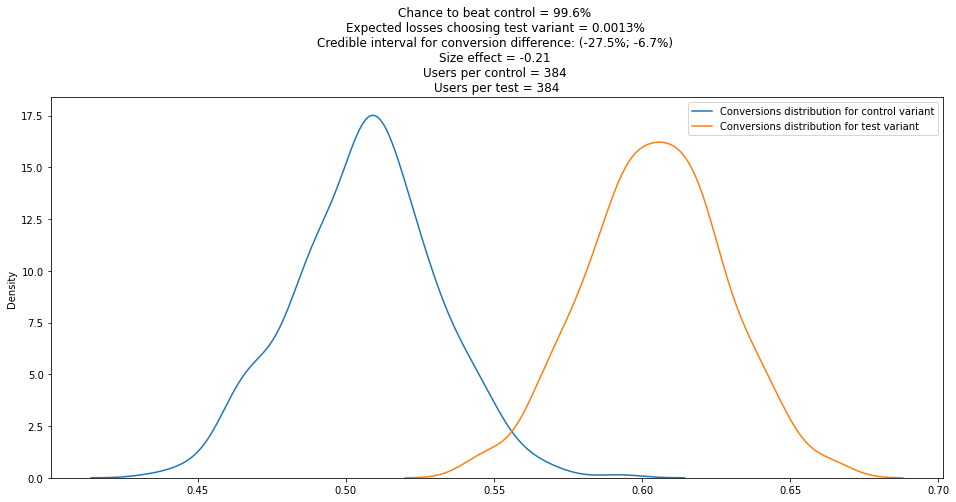

In [16]:
sns.distplot(np.random.beta(195, 384-195, 384), kde=True, hist=False);
sns.distplot(np.random.beta(232, 384-232, 384), kde=True, hist=False);
plt.legend(['Conversions distribution for control variant',
            'Conversions distribution for test variant']);
plt.title(f"Chance to beat control = 99.6% \n"
          f"Expected losses choosing test variant = 0.0013% \n"
          f"Credible interval for conversion difference: (-27.5%; -6.7%) \n"
          f"Size effect = -0.21 \n"
          f"Users per control = 384 \n"
          f"Users per test = 384");

In [30]:
get_size_zratio(10, 11)

12238

In [31]:
get_bayes_metrics(0, p1=0.09, p2=0.1, size=3000)

(0.832111,
 0.0006806255896345208,
 -0.07054024545772736,
 -0.02485664668921717,
 -0.21329848280132235,
 0.07444753498170642)

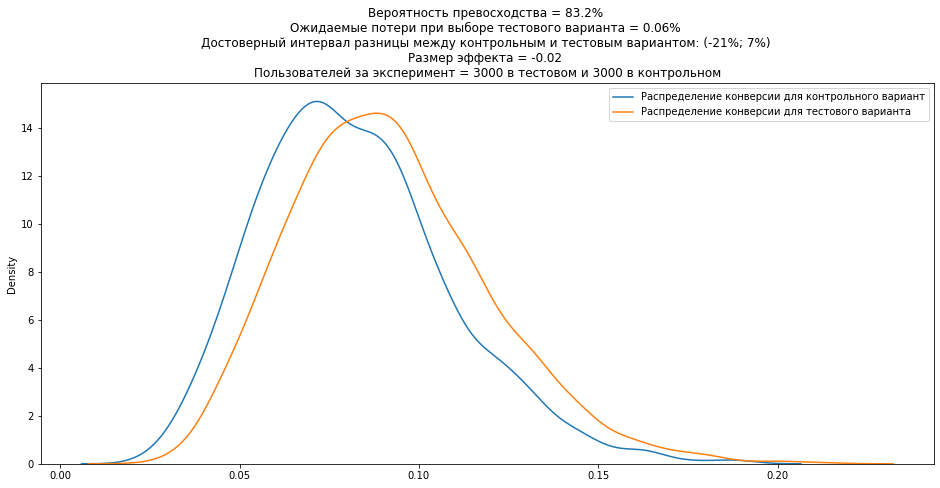

In [60]:
sns.distplot(np.random.beta(9, 100, 3000), kde=True, hist=False);
sns.distplot(np.random.beta(10, 100, 3000), kde=True, hist=False);
plt.title("Результаты байесовского теста");
plt.legend(['Распределение конверсии для контрольного вариант', 
            'Распределение конверсии для тестового варианта']);
plt.title(f"Вероятность превосходства = 83.2% \n"
          f"Ожидаемые потери при выборе тестового варианта = 0.06% \n"
          f"Достоверный интервал разницы между контрольным и тестовым вариантом: (-21%; 7%) \n"
          f"Размер эффекта = -0.02 \n"
          f"Пользователей за эксперимент = 3000 в тестовом и 3000 в контрольном");

# 4. Ранняя остановка теста

В отличие от классических тестов, в случае байесовских методов проблема подглядывания уже не так ярко-выражена и не приводит к существенному увеличению наших ошибок. Следовательно, при достижении определенных целевых значений для ряда критериев остановки мы можем прерывать тест, не дожидаясь накопления достаточного числа пользователей (как в случае классического AB-теста). Однако, делать это нужно аккуратно, опираясь на ряд критериев, описанных выше.

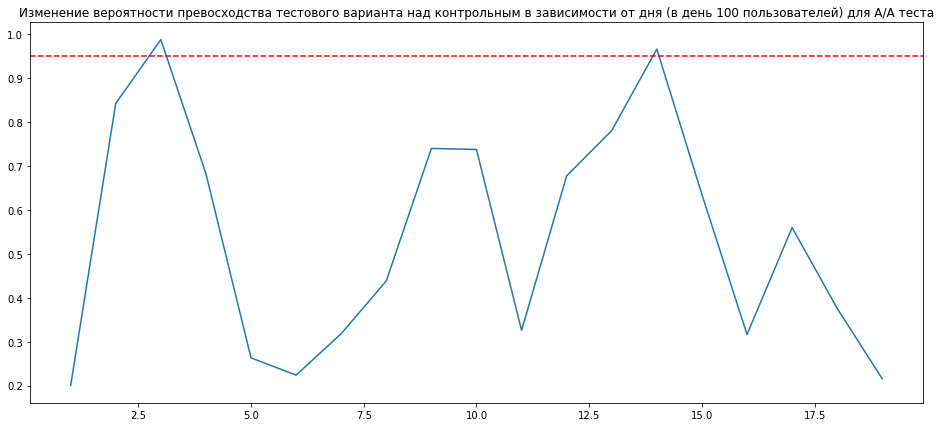

In [49]:
ctba = []
for day in range(1, 20):
    np.random.seed(day * 1)
    alpha1 = np.sum(np.random.binomial(n=1, p=0.3, size=100))
    beta1 = 100 - alpha1
    np.random.seed(day * 2)
    alpha2 = np.sum(np.random.binomial(n=1, p=0.3, size=100))
    beta2 = 100 - alpha2
    ctba.append(calc_prob_between([alpha1, alpha2], [beta1, beta2]))
sns.lineplot(x = np.arange(1, 20), y = ctba);
plt.title(f"Изменение вероятности превосходства тестового варианта над контрольным в зависимости от дня "
          f"(в день 100 пользователей) "
          f"для А/А теста"
    );
plt.axhline(y=0.95, color='r', linestyle='--');

# 5. Алгоритм Томпсона для задачи многоруких бандитов

Данный метод перераспределят пользователей по группам в зависимости от текущей вероятности превосходства. На первом шаге пользователи распределяются равномерно - 50 на 50. Затем после получения новых данных, вероятности превосходства пересчитываются и новые пользователи распределяются в группы, согласно вероятностям превосходства.
Решение об остановке эксперимента принимается на основании критериев, описанных в п.5. 
Отметим, что из-за диспропорций в перераспределении трафика, ошибки 1,2 рода могут выйти из под контроля.
(рисунок с перераспределением трафика)


# 6. Пример реализации Байесовских тестов на конверсию

Будем пользоваться пакетом abyes и собственными вычислениями
В этом пакете мы можем выбрать несколько критериев:
- decision_var = ['es' - effect size; 'lift' - разница эффектов]
- rule = ['loss', 'rope']

Возьмем конверсии со средними по размеру значениями и существенным улучшением: 22% (контрольный вариант)
против 25% (тестовый вариант). - 14% улучшение

In [52]:
n_obs_classic = get_size_zratio(22, 30, 0.05, 0.2)
print(f"Нужно пользователей для классического теста: {n_obs_classic}")
print(f"Попробуем провести Байесовский тест с: {n_obs_classic / 2}")

Нужно пользователей для классического теста: 677
Попробуем провести Байесовский тест с: 338.5


In [54]:
get_bayes_metrics(0, p1=0.22, p2=0.28, size=338)

(0.985698,
 0.00016221007898564694,
 -0.257562284818952,
 -0.16837648980555456,
 -0.45609810995536304,
 -0.04611720841775868)

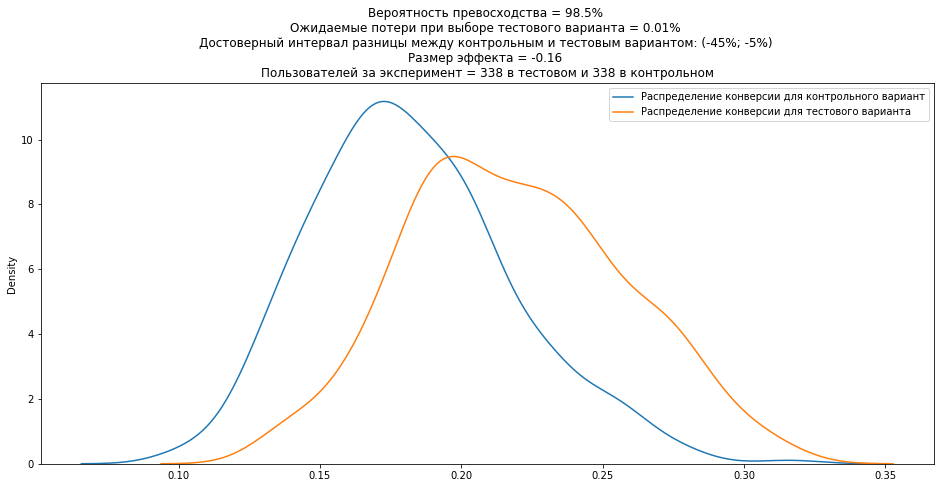

In [59]:
sns.distplot(np.random.beta(22, 100, 338), kde=True, hist=False);
sns.distplot(np.random.beta(28, 100, 338), kde=True, hist=False);
plt.title("Результаты байесовского теста");
plt.legend(['Распределение конверсии для контрольного вариант', 
            'Распределение конверсии для тестового варианта']);
plt.title(f"Вероятность превосходства = 98.5% \n"
          f"Ожидаемые потери при выборе тестового варианта = 0.01% \n"
          f"Достоверный интервал разницы между контрольным и тестовым вариантом: (-45%; -5%) \n"
          f"Размер эффекта = -0.16 \n"
          f"Пользователей за эксперимент = 338 в тестовом и 338 в контрольном");

## Эксперименты (не относятся к базе знаний)

In [58]:
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.025182 0.97462 ]
Ожидаемые потери: [0.03083 0.00015]
95% достоверные интервалы для разницы средних конверсий: [-0.22687 -0.00357]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,1500,1500,0.228,0.258667,0.176016,0.191758,-0.071514,"[-0.22686647481207367, -0.0035660033427575843]"


Видим, что 95% достоверный интервал задевает нулевое значение. Давайте попробуем добавить пользователей и пересчитать все показатели.

### Число юзеров = 1750

In [59]:
np.random.seed(0)
data = np.random.binomial([1, 1], [0.22, 0.25], size=(1750, 2))
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.041463 0.958424]
Ожидаемые потери: [0.02539 0.00024]
95% достоверные интервалы для разницы средних конверсий: [-0.19947  0.01109]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,1750,1750,0.231429,0.256571,0.177869,0.190743,-0.058566,"[-0.19947094561735423, 0.011088289608642166]"


Видим, что достоверные интервалы снова включают нулевое значение, а значит принять решение о победителе все еще опасно.
Давайте добавим еще пользователей.

### Число юзеров = 2000

In [60]:
np.random.seed(0)
data = np.random.binomial([1, 1], [0.22, 0.25], size=(2000, 2))
alphas, betas = data.sum(axis=0), data.shape[0] - data.sum(axis=0)
ctbc, expected_losses, ctba, results_df = bayesian_metrics(alphas, betas)
print(f"Вероятность превосходства над контрольным вариантом: {ctbc}")
print(f"Ожидаемые потери: {np.round(expected_losses, 5)}")
print(f"95% достоверные интервалы для разницы средних конверсий: {np.round(results_df['HDI_lift'].values[0], 5)}")
results_df

Вероятность превосходства над контрольным вариантом: [0.007042 0.992999]
Ожидаемые потери: [3.305e-02 3.000e-05]
95% достоверные интервалы для разницы средних конверсий: [-0.22572 -0.03152]


,,n1,n2,mu1,mu2,var1,var2,effect_size,HDI_lift
var1,var2,,,,,,,,
0,1,2000,2000,0.221,0.254,0.172159,0.189484,-0.077605,"[-0.22572247903134146, -0.03152450291074682]"


Видим, что достоверные интервалы теперь уверенно не включают нулевое значение.
Также заметим, что с  добавлением числа новых пользователей достоверные интервалы сначала расширились и включили в себя нулевое значение,
а потом снова сузились.

На этом примере можно наглядно увидеть, что критерии принятия решений довольно нестабильны во времени,
из-за чего процесс остановки теста может быть опасен.

Давайте сгенерируем 1000 случайных рядов с теми же параметрами и посмотрим, в каком % случаев
мы правильно выберем победителя. Собственно это и будет называться нашим экспериментом!

### Число юзеров = 1500

  0%|          | 0/1000 [00:00<?, ?it/s]

Количество правильно проведенных тестов с критерием превосходства в 0.95: 618


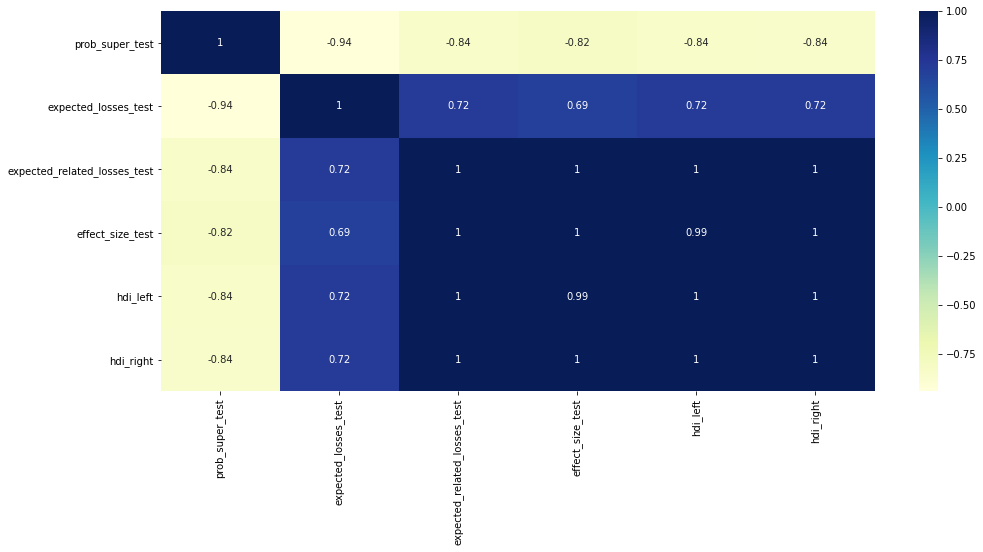

In [20]:
results = list(p_map(partial(get_bayes_metrics, p1=0.22, p2=0.25, size=1500), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test >= 0.95").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.95: {n_correct_tests}")

Идентичные пары критериев:
- chance to beat control и expected loss (0.94 корреляция)
- expected related losses и effect size (0.99 корреляция)
- HDI и effect size (0.99 корреляция)
- expected related losses и HDI (0.99 корреляция)

Давайте добавим еще один критерий - порог для ожидаемых потерь как советуют делать в VWO.

In [27]:
print(f"Порог для ожидаемых потерь по мнению VWO: {0.022 * 0.001 * 100}")

Порог для ожидаемых потерь по мнению VWO: 0.0022


In [26]:
df.query("prob_super_test >= 0.95 & expected_losses_test <= 0.0022")

,prob_super_test,expected_losses_test,expected_related_losses_test,effect_size_test,hdi_left,hdi_right
0,0.975080,0.000149,-0.116831,-0.071514,-0.226683,-0.003442
1,0.999527,0.000002,-0.194952,-0.121173,-0.297899,-0.088978
2,0.997943,0.000009,-0.173920,-0.104912,-0.280864,-0.062792
4,0.994100,0.000029,-0.149725,-0.092152,-0.256053,-0.038926
5,0.999650,0.000001,-0.199363,-0.123301,-0.303434,-0.094111
...,...,...,...,...,...,...
991,0.963708,0.000224,-0.108786,-0.065659,-0.221092,0.006368
994,0.997891,0.000010,-0.167183,-0.104383,-0.272451,-0.060382
995,0.999486,0.000002,-0.195693,-0.119328,-0.300625,-0.087335
996,0.991860,0.000041,-0.148099,-0.087708,-0.260421,-0.034325


Как мы видим, ничего абсолютно не изменилось. Это как раз следствие того, что ожидаемые потери сильно коррелирут с вероятностью превосходства и идентично взаимодополняют друг друга.

In [28]:
# Давайте снизим порог для вероятности превосходства до 90%
n_correct_tests = df.query("prob_super_test >= 0.9").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.9: {n_correct_tests}")

Количество правильно проведенных тестов с критерием превосходства в 0.9: 747


### Число юзеров = 2000

  0%|          | 0/1000 [00:00<?, ?it/s]

Количество правильно проведенных тестов с критерием превосходства в 0.95: 722


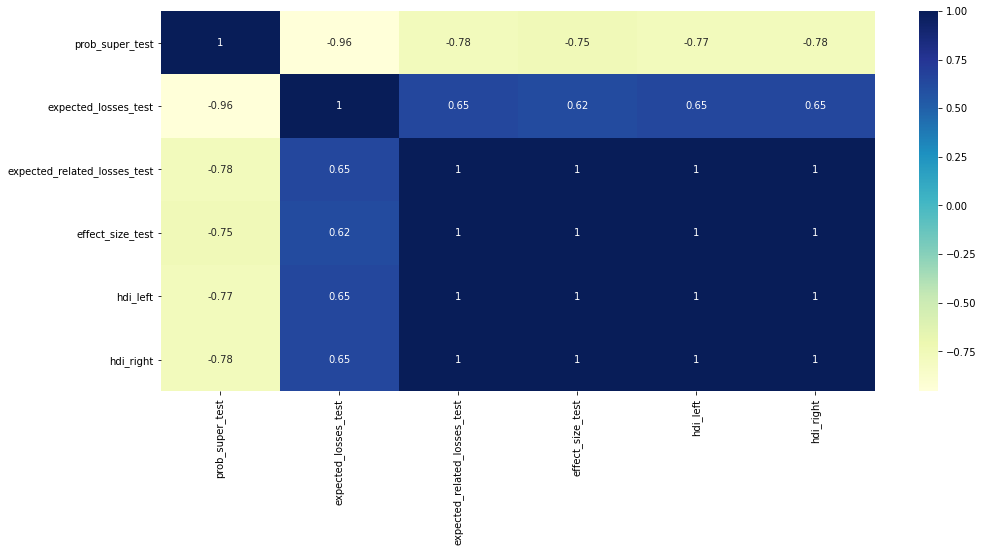

In [29]:
results = list(p_map(partial(get_bayes_metrics, p1=0.22, p2=0.25, size=2000), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test >= 0.95").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.95: {n_correct_tests}")

In [32]:
n_correct_test_VWO = df.query("prob_super_test >= 0.95 & expected_losses_test <= 0.0022").shape[0]
print(f"Количество правильно проведенных тестов с критерием VWO: {n_correct_test_VWO}")

Количество правильно проведенных тестов с критерием VWO: 722


In [33]:
n_correct_tests = df.query("prob_super_test >= 0.9").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 0.9: {n_correct_tests}")

Количество правильно проведенных тестов с критерием превосходства в 0.9: 837


Казалось бы, давайте снижать порог для вероятности превосходства и дело в шляпе!
Но не тут-то было!
Теперь давайте проведем AA-тесты. Теперь мы будем генерировать выборки с одним и тем же математическим ожиданием.


  0%|          | 0/1000 [00:00<?, ?it/s]

Количество правильно проведенных тестов с критерием превосходства в 80%: 797


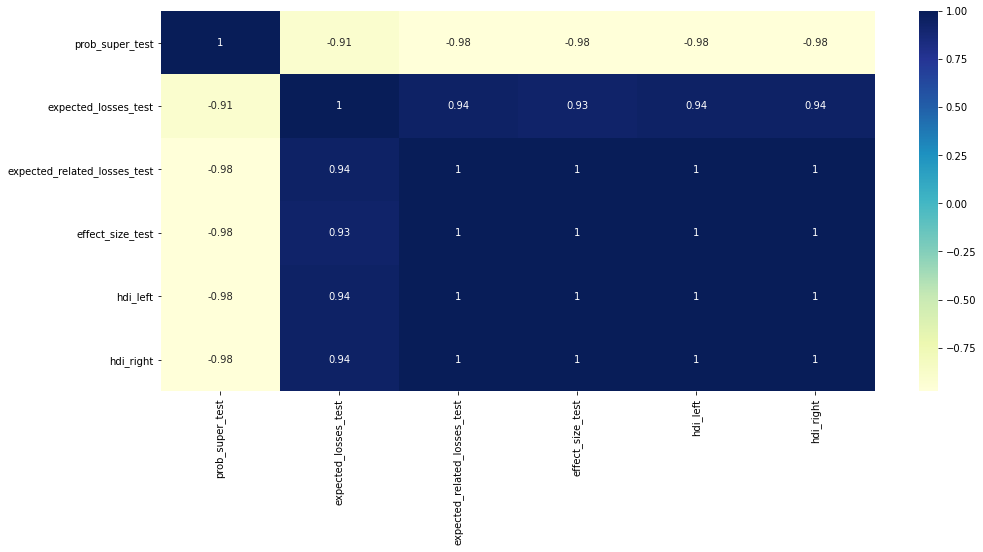

In [34]:
results = list(p_map(partial(get_bayes_metrics, p1=0.22, p2=0.22, size=2000), range(1000)))
df = pd.DataFrame(results)
df.columns = ['prob_super_test', 'expected_losses_test', 'expected_related_losses_test',
              'effect_size_test', 'hdi_left', 'hdi_right']
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
n_correct_tests = df.query("prob_super_test <= 0.8").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 80%: {n_correct_tests}")

Как мы видим, AA тест показал 20% ошибку 1 рода - мы обнаружили эффект там, где его на самом деле нет.

Теперь снова увеличим порог для вероятности превосходства в 95%.

In [35]:
n_correct_tests = df.query("prob_super_test <= 0.95").shape[0]
print(f"Количество правильно проведенных тестов с критерием превосходства в 95%: {n_correct_tests}")

Количество правильно проведенных тестов с критерием превосходства в 95%: 957


Давайте теперь сгенерируем ряды с одинаковым математическим ожиданием и проверим гипотезу при помощи готового пакета PyMC3

Running on PyMC3 v3.11.4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 25 seconds.


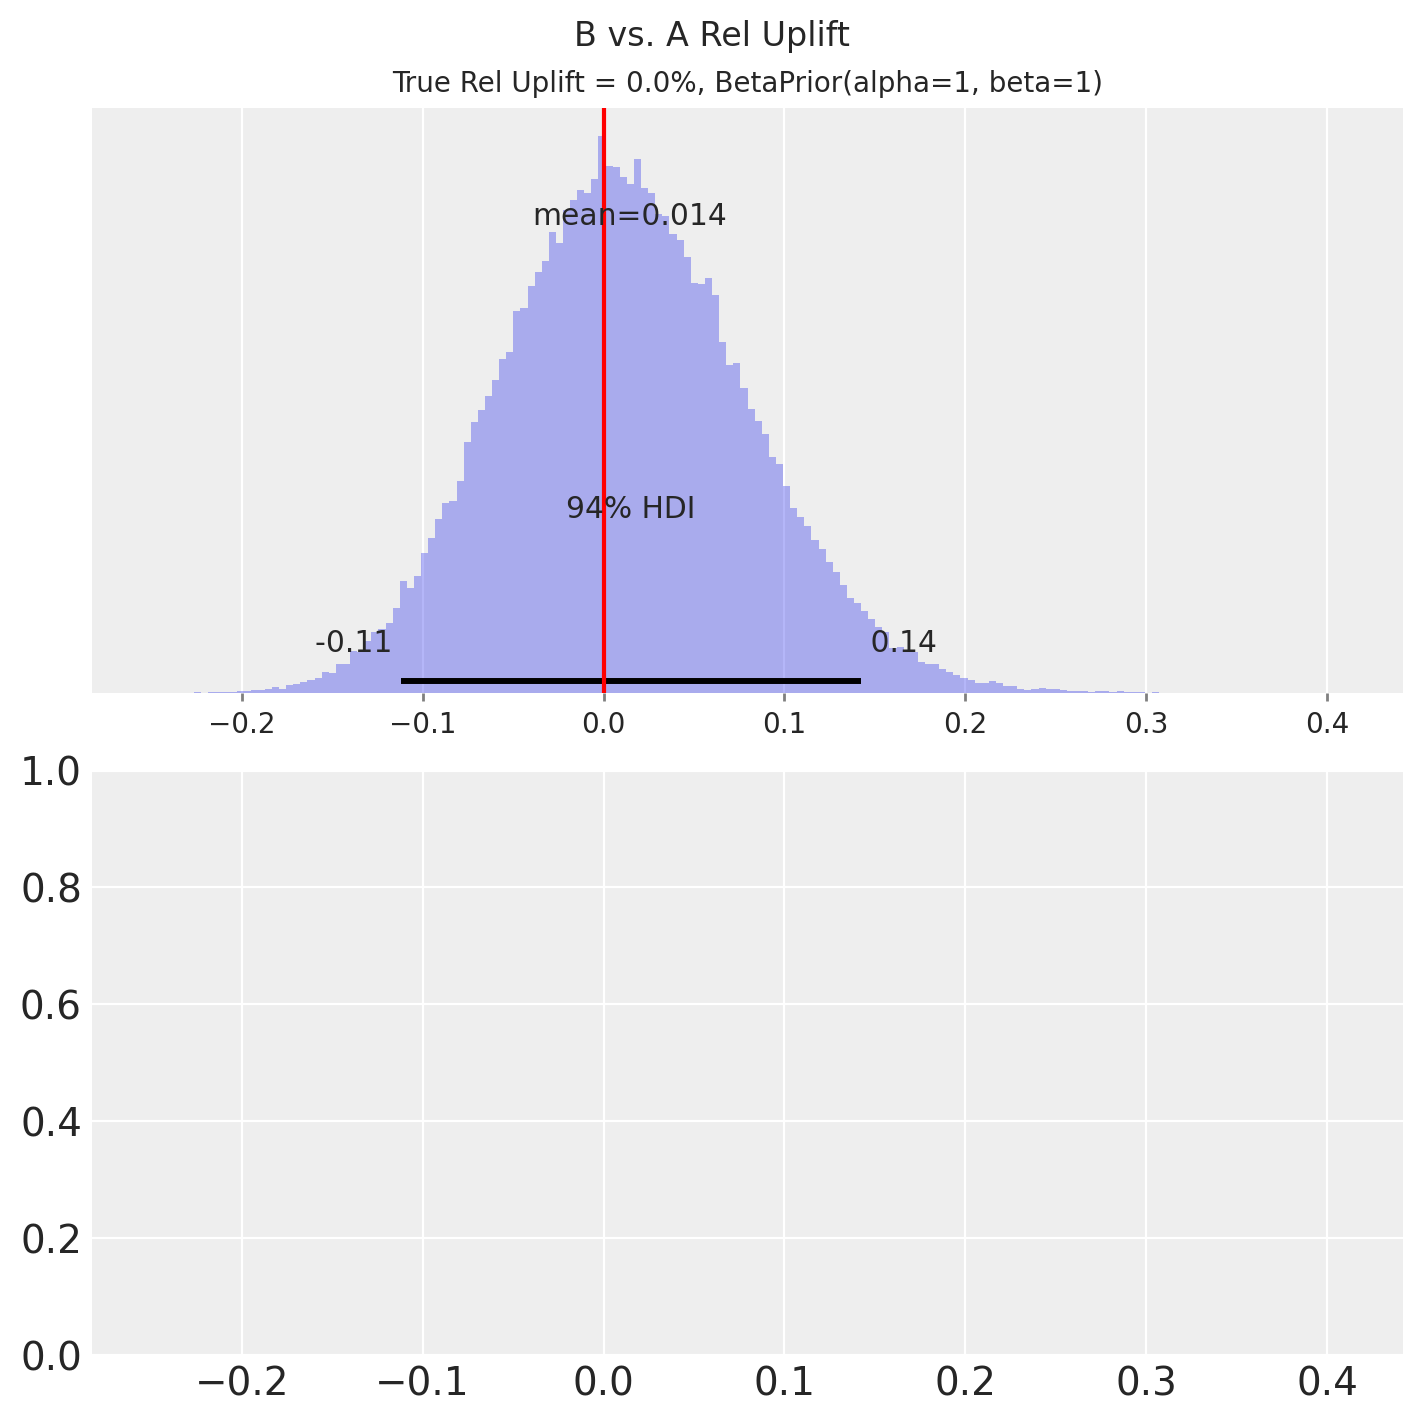

In [113]:
print(f"Running on PyMC3 v{pm.__version__}")
%config InlineBackend.figure_format = 'retina'

az.style.use("arviz-darkgrid")
data_pymc3 = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.22, 0.22],
    samples_per_variant=1500,
    our_prior=BetaPrior(alpha=1, beta=1)
    # weak_prior=BetaPrior(alpha=100, beta=100),
    # strong_prior=BetaPrior(alpha=10000, beta=10000),
)

### Пример байесовского теста на конверсию с ранней остановкой

Теперь воспользуемся другим пакетом и смоделируем тестирование с остановкой при наступлении определенных критериев.
Установим минимальное число для остановки теста в 1500 юзеров.
Предположим, что ежедневно к нам будет поступать порядка от 100 до 200 пользователей в каждый вариант.

In [10]:
# CPRIOR package for conversion rates
from scipy import stats
e = bayes_conversion_stop_experiment(min_n_samples=1500, 
                                     max_n_samples=2000,
                                     p1=0.22, p2=0.22,
                                     criterion="probability_vs_all", criterion_value=0.95, seed=0)
print(e.winner)

None


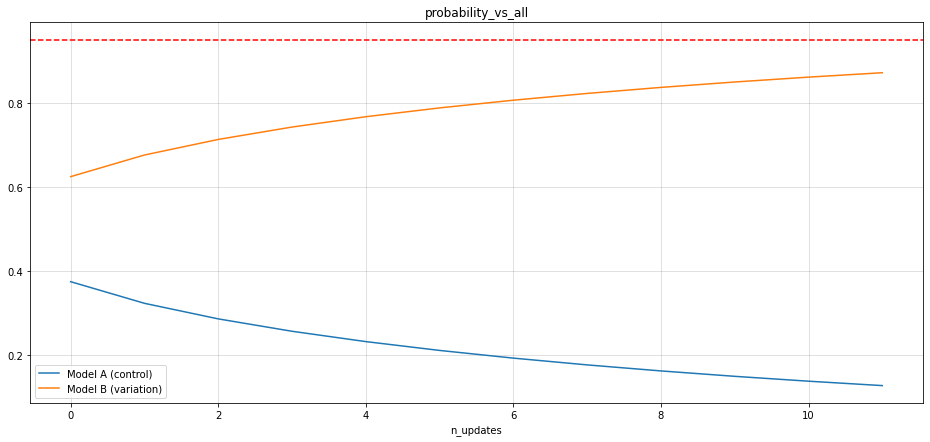

In [11]:
e.plot_metric()

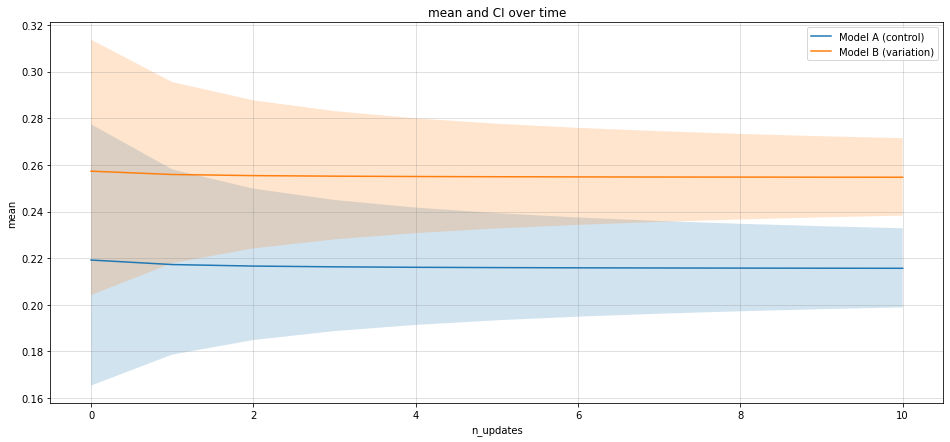

In [69]:
e.plot_stats()

На первый взгляд кажется, что все отлично и никаких проблем при выборе победителя для теста с остановкой быть не должно.
Однако, давайте запустим 1000 экспериментов и посмотрим на долю верно определенных победителей.

In [40]:
results = list(p_map(partial(bayes_conversion_stop_experiment,
                             1500, 3000,
                             0.22, 0.25,
                             "probability_vs_all", 0.95), range(1000)))
from collections import Counter
Counter([i.winner for i in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Counter({'B': 595, None: 246, 'A': 159})

Видим, что только для 60% всех тестов мы верно выбрали победителя при пороге вероятности превосходства в 95%.

Давайте проведем АА-тест

In [41]:
results = list(p_map(partial(bayes_conversion_stop_experiment,
                             1500, 3000,
                             0.22, 0.22,
                             "probability_vs_all", 0.95), range(1000)))
from collections import Counter
Counter([i.winner for i in results])

  0%|          | 0/1000 [00:00<?, ?it/s]

Counter({None: 285, 'B': 362, 'A': 353})

Ошибка 1 рода в этом случае составила целых 70%! В 35% случаев мы выбрали B в качестве победителя и в 35% случаев - А. В этом и заключается проблема байесовских тестов с остановкой. Давайте посмотрим, что об этом пишет Google Optimize (https://support.google.com/optimize/answer/9988285?hl=en&ref_topic=9127922):

`As alluded to above, Optimize does not focus on false positives. One reason to not focus on false positives is we believe they will never happen in a real experiment. A false positive happens when we conclude a difference between treatments when in fact there was no difference. However, we believe there is always some difference between treatments - it’s just a matter of the magnitude of the difference and which treatment is better. Instead of focusing on false positives, Optimize makes a recommendation if it's confident that the recommendation is suboptimal by only a negligible amount.`

`Controlling the false positive rate, as NHST does, perhaps makes sense when a false positive could exist and its consequences are high. For example, perhaps when scientists declare discoveries as scientifically true they want a very small proportion to be false - a loss of faith in science or one’s professional reputation may be at stake. However, when making business decisions Optimize believes there is little reason to emphasize false positive rate over other kinds of errors.`

`A consequence of this is that our false positive rate is likely higher than testing tools that focus on this. For example, testing tools that use Null Hypothesis Significance Testing (NHST) with a significance threshold set to 95% often control the false positive rate to be at most 5% (assuming the multiple comparisons and peeking problems have been accounted for if necessary). In an A/A test where there is no difference between the treatments, there is an expectation that an NHST testing tool will recommend a treatment at most 5% of the time. This is why A/A tests are a useful way to check if an NHST testing tool is doing what it’s supposed to do.`

`Optimize on the other hand doesn’t focus on false positives so there should be no expectation that A/A tests in Optimize will recommend a treatment only 5% of the time. If Optimize is confident that there is a treatment that is suboptimal by only a negligible amount, it will make a recommendation. In an A/A test, Optimize makes a good recommendation according to its own criteria as the suboptimality of one A instead of the other A is zero. Optimize’s recommended treatment in an A/A test ought to be reviewed together with the modeled improvement. You will likely see the modeled improvement is negligible.`



# 7. Пример байесовского теста на ARPU

# 8. Пример алгоритма Томпсона на конверсию

In [76]:
# np.random.seed(100)
# modelA = BernoulliModel(alpha=1, beta=1)
# modelB = BernoulliModel(alpha=1, beta=1)
#
# test = BernoulliABTest(modelA=modelA, modelB=modelB)
# test.update_A([0, 1])
#
# test.update_B([0, 1])
# batch_size = 10
# p_control_percent, mde_percent = 2, 0
# n_obs_every_arm = get_size_zratio(p_control_percent, mde_percent, alpha=0.05, beta=0.2)
# p1, mde_test = p_control_percent / 100, -(p_control_percent * mde_percent) / 10000
# p2 = p1 - mde_test
# probability_superiority_step_list = []  # how share of traffic changes across experiment
# observations_step_list = np.array([0, 0])  # how many observations is cumulated in every step
# expected_loss_step_list = []
# alphas_step_list, betas_step_list = np.array([0, 0]), np.array([0, 0])
# criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
#                  (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
#                  (np.sum(observations_step_list) < n_obs_every_arm * 3)
# while criterion_stop:
#     probability_superiority_step_list.append(test.probability(variant="B"))
#     data_A_size = int(batch_size * test.probability(variant="A"))
#     data_B_size = int(batch_size * test.probability(variant="B"))
#     data_A = np.random.binomial(n=1, p=p1, size=data_A_size)
#     data_B = np.random.binomial(n=1, p=p2, size=data_B_size)
#     alphas_step_list += np.array([data_A.sum(), data_B.sum()])
#     betas_step_list += np.array([data_A_size - data_A.sum(), data_B_size - data_B.sum()])
#     observations_step_list += np.array([data_A_size, data_B_size])
#     test.update_A(data_A)
#     test.update_B(data_B)
#     expected_loss_step_list.append(test.expected_loss(variant="A"))
#     criterion_stop = (test.probability(variant="A") < 0.95) & (test.probability(variant="B") < 0.95) &\
#                      (test.expected_loss_ci(variant="A")[0] < 0 < test.expected_loss_ci(variant="A")[1]) &\
#                      (np.sum(observations_step_list) < n_obs_every_arm * 3)
#     print(observations_step_list)

In [43]:
# Compute P[A > B] and P[B > A]
print("P[A > B] = {:.4f}".format(e.probability(variant="A")))
print("P[B > A] = {:.4f}".format(e.probability(variant="B")))

# Compute posterior expected loss given a variant
print("E[max(B - A, 0)] = {:.4f}".format(e.expected_loss(variant="A")))
print("E[max(A - B, 0)] = {:.4f}".format(e.expected_loss(variant="B")))

P[A > B] = 0.0170
P[B > A] = 0.9830
E[max(B - A, 0)] = 0.0126
E[max(A - B, 0)] = 0.0000


In [77]:
alphas = [100, 120]
betas = [200, 205]
control_thetas = beta.rvs(alphas[0], betas[0], size=10000)
test_thetas = beta.rvs(alphas[1], betas[1], size=10000)
print(f"Вероятность превосходства = {np.sum(test_thetas > control_thetas) / 10000}")


Вероятность превосходства = 0.8285


0.8271